In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

#initializing the class for carrying out Barycentric interpolation
class BaryInterp(object):
  def __init__(self,x,f):
    self.x = x  #the nodes
    self.f = f  #the values of functions at the nodes
    self.weights = np.zeros(len(x))  #arroay of the weight for jth node

    
  ##TO BE TAKEN CARE OF  
  def update(self,x_update,f_update):
    self.x = np.append(self.x,x_update)
    self.f = np.append(self.f,f_update)
    sort_ind = np.argsort(self.x)
    self.x = np.sort(self.x)
    self.f = self.f[sort_ind]
    self.weights = np.zeros(len(x))
    
  #function to calculate the weights  
  def calc_weights(self):
    N = len(self.x)
    W = np.ones([N,N])
    for i in range(1,len(self.x)):
        W[i,:i] = self.x[:i] - self.x[i]  #filling in sub-diagonal entries
        W[i,i] = ((-1)**i)*np.prod(W[i,:i])
    
    W[N-1,:] = np.prod(W,axis=0)
    self.weights = (1.0/W)[-1,:]
    
  #function to carry out the Lagrange interpolation   
  def interp_lagrange(self,x_arg):  #x_arg is the set of new points where we want to interpolate
    self.calc_weights()
    
    interp_eval = np.zeros(len(x_arg))
    
    for i in range(len(x_arg)):    
        if(np.amin(np.abs(x_arg[i] - self.x)) == 0): interp_eval[i] = self.f[np.argmin(np.abs(x_arg[i] - self.x))]
        else: interp_eval[i] += np.sum((self.weights[:]*self.f[:]/(x_arg[i] - self.x[:])))/np.sum((self.weights[:]/(x_arg[i] - self.x[:])))
    return interp_eval


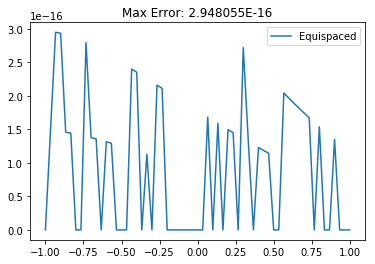

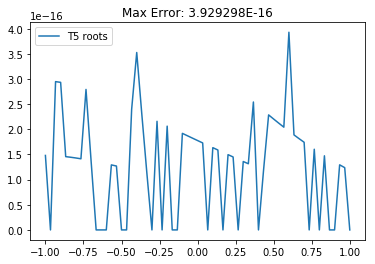

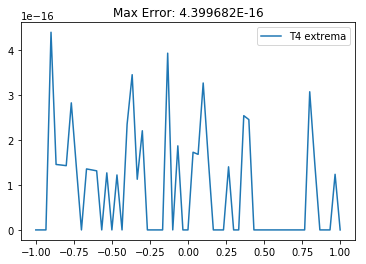

In [28]:
import numpy as np
import numpy.polynomial.chebyshev as cheb

nodes1 = np.linspace(-1,1,5) #domains includes -1 and +1 with 5 eqi-spaced nodes

nodes2 = cheb.chebroots((0, 0, 0, 0, 0, 1))  #returns the roots of T5

x2 = np.linspace(-1,1,61)  #setting up coarser domain to find the maxima/minima of T4

val_cheb_4 = cheb.chebval(x2,[0, 0, 0, 0, 1])  #computing T4
mask = np.zeros(len(x2))
nodes3 = np.zeros(5)   #array for storing the x's corresponding to extremas of T4
for i in range(5):
    max_ind = np.argmax(np.abs(val_cheb_4))
    mask[max_ind] = 1
    val_cheb_4 = np.ma.array(val_cheb_4, mask = mask)  #successively masking the extremas in descending order
    nodes3[i] = x2[max_ind]  #storing the corresponding x values

p = np.poly1d([1,2,3,4,5])  #the polynomial f(x) = x^4 + 2x^3 + 3x^2 + 4x + 5

#Setting up the instances for the different set of nodes 

b1 = BaryInterp(nodes1,p(nodes1))  #equispaced

b2 = BaryInterp(nodes2,p(nodes2))  #T5 nodes

b3 = BaryInterp(nodes3,p(nodes3))  #T4 extremas

err1 = np.abs((p(x2) - b1.interp_lagrange(x2))/p(x2))
err2 = np.abs((p(x2) - b2.interp_lagrange(x2))/p(x2))
err3 = np.abs((p(x2) - b3.interp_lagrange(x2))/p(x2))

#Plotting the relative errors for each case

plt.plot(x2, err1, label='Equispaced')
plt.title('Max Error: %E'%np.amax(err1))
plt.legend()

plt.figure()
plt.plot(x2, err2, label='T5 roots')
plt.title('Max Error: %E'%np.amax(err2))
plt.legend()

plt.figure()
plt.plot(x2, err3, label='T4 extrema')
plt.title('Max Error: %E'%np.amax(err3))

plt.legend()

**Looking at the actual interpolations**

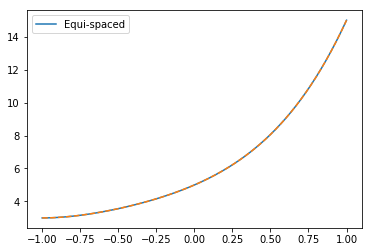

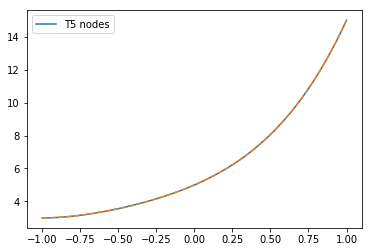

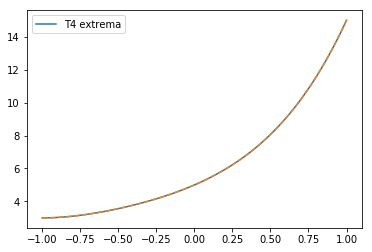

In [31]:
plt.plot(x2, b1.interp_lagrange(x2), label='Equi-spaced')
plt.plot(x2, p(x2),'--')
plt.legend()

plt.figure()
plt.plot(x2, b2.interp_lagrange(x2), label='T5 nodes')
plt.plot(x2, p(x2),'--')
plt.legend()

plt.figure()
plt.plot(x2, b3.interp_lagrange(x2), label='T4 extrema')
plt.plot(x2, p(x2),'--')

plt.legend()